In [1]:
import json

with open("/home/huy/Project/educAItion/data.json", "r", encoding="utf-8") as file:
    data = json.load(file)

question_count = sum(len(topic["questions"]) for chapter in data["data"] for topic in chapter["topics"])

print("Total number of questions:", question_count)


Total number of questions: 162


In [2]:


PROMPT_text = """
Hãy giải bài toán theo từng bước, và giải thích bước làm.
Hãy trả về kết quả dạng LaTeX cho các công thức toán học (để trong $...$ cho các biểu thức, số), bảng biến thiên, đồ thị,... nếu có.

=========
Đây là bài toán:
{problem}

=========

LƯU Ý: 
- Hãy giải bằng cách ngắn gọn, hiệu quả nhất.
- Hãy trình bày khoa học và dùng các ký hiệu toán học nếu có thể để thay cho chữ 
- Ví dụ dùng kí hiệu toán là dấu "hoặc", "và" khi giải phương trình, bất phương trình; Hay vẽ bảng biến thiên khảo sát hàm số hay xét dấu,.... 
- Nên xuống dòng khi cần thiết, tránh một dòng quá dài.
-Trả về dưới dạng tag : <solution>solution<solution> <answer>answer<answer> trong đó solution là cách giải, anser là kết quả cuối cùng theo yêu cầu bài toán.
-Trả về kết quả dưới dạng Latex
"""

In [7]:
from together import Together
import os
deepseek_api = "bc78c30583e4ad9887e42feada1c4ddc320378fc4b44f18d6a9cbdb97ac2ae1c"
client = Together(api_key=deepseek_api)

In [ ]:

import re
import pandas as pd
import os
import json

from IPython.display import display, Latex

from tqdm import tqdm

def get_answer(problem):
        response = client.chat.completions.create(
                model="deepseek-ai/DeepSeek-R1",
                messages=[{"role": "user", "content": PROMPT_text.format(problem=problem)}],
                ).choices[0].message.content
        if response is None:
                return {"solution": "AI failed to generate a solution", "answer": "AI failed to generate an answer"}
        solution_match = re.search(r"<solution>(.*?)</solution>", response, re.DOTALL)
        answer_match = re.search(r"<answer>(.*?)</answer>", response, re.DOTALL)

        # Extracted values or default
        solution = solution_match.group(1) if solution_match else "No solution found"
        answer = answer_match.group(1) if answer_match else "No answer found"

        return {"solution": solution, "answer": answer}

In [ ]:
import time

rows = []
questions_list = [q for chapter in data["data"] for topic in chapter["topics"] for q in topic["questions"]]

for q in tqdm(questions_list[], desc="Processing Questions"):
    ai_response = get_answer(q["question"])  # API Call
    display(Latex(ai_response["solution"]))
    rows.append([
        q["question"], 
        q["solution"], 
        q["answer"], 
        ai_response["solution"], 
        ai_response["answer"]
    ])
    
    time.sleep(60 / 1.2)  # Sleep to respect 1.2 RPM

# Create DataFrame
df = pd.DataFrame(rows, columns=["Question", "Solution", "Answer", "AI Solution", "AI Answer"])


# Display DataFrame
display(df)

In [ ]:
for q in tqdm(questions_list[76:], desc="Processing Questions"):
    ai_response = get_answer(q["question"])  # API Call
    display(Latex(ai_response["solution"]))
    rows.append([
        q["question"], 
        q["solution"], 
        q["answer"], 
        ai_response["solution"], 
        ai_response["answer"]
    ])
    
    time.sleep(60 / 1.2)  # Sleep to respect 1.2 RPM

# Create DataFrame
df = pd.DataFrame(rows, columns=["Question", "Solution", "Answer", "AI Solution", "AI Answer"])


# Display DataFrame
display(df)

In [ ]:
df.to_csv("deepseek_r1_test_results.csv")

# Test results

In [10]:
import pandas as pd
from abc import ABC, abstractmethod
from google import genai

import re
import pandas as pd
import os
import json
from IPython.display import display, Latex
from tqdm import tqdm

df = pd.read_csv("deepseek_r1_test_results.csv")
gemini_api_key = os.getenv("GOOGLE_API_KEY")


class LLM(ABC):
    @abstractmethod
    def generate(self, prompt: str) -> str:
        pass
    
    @abstractmethod
    def stream_generate(self, prompt: str):
        pass

        
class GeminiAI(LLM):
    def __init__(self):
        self.client = genai.Client(api_key=gemini_api_key)
    
    def generate(self, prompt: str) -> str:
        response = self.client.models.generate_content(model="gemini-2.0-flash",contents=[prompt])
        return response.text
    

    def stream_generate(self, prompt: str):
        response = self.client.models.generate_content_stream(model="gemini-2.0-flash",contents=[prompt])
        
        for chunk in response:
            if chunk.text:
                yield chunk.text
        pass

model = GeminiAI()

In [11]:
import time
import re
import pandas as pd
from tqdm import tqdm

# Function to classify AI answer correctness
def check_answer(correct_answer, ai_answer):
    prompt = (f'''Compare the correct answer '{correct_answer}' with the AI-generated answer '{ai_answer}'. 
              Categorize the result into one of the following:
              1. 'Both Correct' - AI answer is meaningfully correct.
              2. 'Both Incorrect' - AI uses incorrect reasoning, both are incorrect.
              3. 'Correct Answer, Wrong Explanation' - The answer is correct, but the reasoning is flawed.
              4. 'Wrong Answer, Correct Explanation' - The answer is wrong, but the reasoning is valid.
              5. 'AI Not Generated' - AI did not produce an answer.
              
              Be lenient in formatting and minor differences as long as the meaning aligns. 
              Return only the category and a brief explanation.
              ''')

    global last_api_call_time

    # Enforce rate limit (one request every 4 seconds)
    elapsed_time = time.time() - last_api_call_time
    if elapsed_time < 4:
        time.sleep(4 - elapsed_time)

    response = model.generate(prompt)  # API call
    last_api_call_time = time.time()

    if not response:
        return "AI Not Generated", "AI failed to generate a response"

    # Ensure response is a string before applying regex
    response = str(response)

    match = re.search(r"(Both Correct|Both Incorrect|Correct Answer, Wrong Explanation|Wrong Answer, Correct Explanation|AI Not Generated)", response)
    explanation_match = re.search(r"Explanation:\s*(.*)", response, re.DOTALL)

    category = match.group(1) if match else "Unknown"
    explanation = explanation_match.group(1).strip() if explanation_match else "No explanation provided"

    return category, explanation

# Initialize rate limit tracking
last_api_call_time = time.time()

# Ensure necessary columns exist
if "Category" not in df.columns:
    df["Category"] = None
if "Explanation" not in df.columns:
    df["Explanation"] = None

# Process only unanswered rows
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Checking AI Answers"):
    if pd.notna(row["Category"]):  # Skip rows already processed
        continue
    
    category, explanation = check_answer(row["Answer"], row["AI Answer"])
    df.at[index, "Category"] = category
    df.at[index, "Explanation"] = explanation

    print(f"Processed {index + 1}/{df.shape[0]} - Category: {category}")  # Progress tracking

# Display updated DataFrame
display(df)


Checking AI Answers:   1%|          | 1/162 [00:04<12:59,  4.84s/it]

Processed 1/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:   1%|          | 2/162 [00:10<14:06,  5.29s/it]

Processed 2/162 - Category: Both Correct


Checking AI Answers:   2%|▏         | 3/162 [00:15<13:24,  5.06s/it]

Processed 3/162 - Category: Both Correct


Checking AI Answers:   2%|▏         | 4/162 [00:20<13:56,  5.29s/it]

Processed 4/162 - Category: AI Not Generated


Checking AI Answers:   3%|▎         | 5/162 [00:26<14:06,  5.39s/it]

Processed 5/162 - Category: Both Correct


Checking AI Answers:   4%|▎         | 6/162 [00:31<13:24,  5.16s/it]

Processed 6/162 - Category: Both Correct


Checking AI Answers:   4%|▍         | 7/162 [00:35<12:56,  5.01s/it]

Processed 7/162 - Category: Both Correct


Checking AI Answers:   5%|▍         | 8/162 [00:41<13:19,  5.19s/it]

Processed 8/162 - Category: Both Correct


Checking AI Answers:   6%|▌         | 9/162 [00:47<13:32,  5.31s/it]

Processed 9/162 - Category: Both Correct


Checking AI Answers:   6%|▌         | 10/162 [00:51<13:00,  5.14s/it]

Processed 10/162 - Category: Both Correct


Checking AI Answers:   7%|▋         | 11/162 [00:57<13:17,  5.28s/it]

Processed 11/162 - Category: Both Correct


Checking AI Answers:   7%|▋         | 12/162 [01:02<13:24,  5.36s/it]

Processed 12/162 - Category: Both Correct


Checking AI Answers:   8%|▊         | 13/162 [01:08<13:34,  5.46s/it]

Processed 13/162 - Category: Both Correct


Checking AI Answers:   9%|▊         | 14/162 [01:14<13:36,  5.52s/it]

Processed 14/162 - Category: Both Correct


Checking AI Answers:   9%|▉         | 15/162 [01:19<13:35,  5.55s/it]

Processed 15/162 - Category: Both Correct


Checking AI Answers:  10%|▉         | 16/162 [01:24<12:56,  5.32s/it]

Processed 16/162 - Category: Both Correct


Checking AI Answers:  10%|█         | 17/162 [01:30<13:04,  5.41s/it]

Processed 17/162 - Category: Both Correct


Checking AI Answers:  11%|█         | 18/162 [01:34<12:28,  5.20s/it]

Processed 18/162 - Category: Both Correct


Checking AI Answers:  12%|█▏        | 19/162 [01:40<12:43,  5.34s/it]

Processed 19/162 - Category: Both Correct


Checking AI Answers:  12%|█▏        | 20/162 [01:45<12:27,  5.27s/it]

Processed 20/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  13%|█▎        | 21/162 [01:51<12:40,  5.39s/it]

Processed 21/162 - Category: Both Correct


Checking AI Answers:  14%|█▎        | 22/162 [01:56<12:12,  5.23s/it]

Processed 22/162 - Category: Both Correct


Checking AI Answers:  14%|█▍        | 23/162 [02:00<11:43,  5.06s/it]

Processed 23/162 - Category: Both Correct


Checking AI Answers:  15%|█▍        | 24/162 [02:06<11:56,  5.19s/it]

Processed 24/162 - Category: Both Correct


Checking AI Answers:  15%|█▌        | 25/162 [02:12<12:25,  5.44s/it]

Processed 25/162 - Category: Both Incorrect


Checking AI Answers:  16%|█▌        | 26/162 [02:17<11:58,  5.28s/it]

Processed 26/162 - Category: Both Correct


Checking AI Answers:  17%|█▋        | 27/162 [02:22<12:00,  5.34s/it]

Processed 27/162 - Category: Both Correct


Checking AI Answers:  17%|█▋        | 28/162 [02:28<12:05,  5.41s/it]

Processed 28/162 - Category: Both Correct


Checking AI Answers:  18%|█▊        | 29/162 [02:34<12:10,  5.49s/it]

Processed 29/162 - Category: Both Correct


Checking AI Answers:  19%|█▊        | 30/162 [02:38<11:39,  5.30s/it]

Processed 30/162 - Category: Both Correct


Checking AI Answers:  19%|█▉        | 31/162 [02:43<11:17,  5.17s/it]

Processed 31/162 - Category: Both Correct


Checking AI Answers:  20%|█▉        | 32/162 [02:48<10:58,  5.07s/it]

Processed 32/162 - Category: Both Correct


Checking AI Answers:  20%|██        | 33/162 [02:54<11:17,  5.25s/it]

Processed 33/162 - Category: Both Correct


Checking AI Answers:  21%|██        | 34/162 [03:00<11:30,  5.39s/it]

Processed 34/162 - Category: Both Correct


Checking AI Answers:  22%|██▏       | 35/162 [03:05<11:39,  5.50s/it]

Processed 35/162 - Category: Both Correct


Checking AI Answers:  22%|██▏       | 36/162 [03:11<11:38,  5.54s/it]

Processed 36/162 - Category: Both Correct


Checking AI Answers:  23%|██▎       | 37/162 [03:17<11:35,  5.56s/it]

Processed 37/162 - Category: Both Correct


Checking AI Answers:  23%|██▎       | 38/162 [03:21<11:03,  5.35s/it]

Processed 38/162 - Category: Both Correct


Checking AI Answers:  24%|██▍       | 39/162 [03:26<10:35,  5.16s/it]

Processed 39/162 - Category: Both Correct


Checking AI Answers:  25%|██▍       | 40/162 [03:32<10:50,  5.33s/it]

Processed 40/162 - Category: Both Correct


Checking AI Answers:  25%|██▌       | 41/162 [03:37<10:55,  5.42s/it]

Processed 41/162 - Category: Both Correct


Checking AI Answers:  26%|██▌       | 42/162 [03:43<11:04,  5.54s/it]

Processed 42/162 - Category: Both Correct


Checking AI Answers:  27%|██▋       | 43/162 [03:49<11:04,  5.58s/it]

Processed 43/162 - Category: Both Correct


Checking AI Answers:  27%|██▋       | 44/162 [03:54<10:50,  5.51s/it]

Processed 44/162 - Category: Both Correct


Checking AI Answers:  28%|██▊       | 45/162 [04:01<11:10,  5.73s/it]

Processed 45/162 - Category: Both Correct


Checking AI Answers:  28%|██▊       | 46/162 [04:06<11:01,  5.70s/it]

Processed 46/162 - Category: Both Correct


Checking AI Answers:  29%|██▉       | 47/162 [04:12<10:57,  5.72s/it]

Processed 47/162 - Category: Both Correct


Checking AI Answers:  30%|██▉       | 48/162 [04:18<11:00,  5.79s/it]

Processed 48/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  30%|███       | 49/162 [04:24<10:56,  5.81s/it]

Processed 49/162 - Category: Both Correct


Checking AI Answers:  31%|███       | 50/162 [04:29<10:30,  5.63s/it]

Processed 50/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  31%|███▏      | 51/162 [04:34<09:51,  5.33s/it]

Processed 51/162 - Category: Both Correct


Checking AI Answers:  32%|███▏      | 52/162 [04:39<09:37,  5.25s/it]

Processed 52/162 - Category: Both Correct


Checking AI Answers:  33%|███▎      | 53/162 [04:44<09:48,  5.40s/it]

Processed 53/162 - Category: Both Correct


Checking AI Answers:  33%|███▎      | 54/162 [04:50<09:54,  5.51s/it]

Processed 54/162 - Category: Both Correct


Checking AI Answers:  34%|███▍      | 55/162 [04:55<09:20,  5.24s/it]

Processed 55/162 - Category: Both Correct


Checking AI Answers:  35%|███▍      | 56/162 [05:01<09:38,  5.46s/it]

Processed 56/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  35%|███▌      | 57/162 [05:06<09:17,  5.31s/it]

Processed 57/162 - Category: Both Correct


Checking AI Answers:  36%|███▌      | 58/162 [05:12<09:34,  5.52s/it]

Processed 58/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  36%|███▋      | 59/162 [05:17<09:13,  5.37s/it]

Processed 59/162 - Category: Both Correct


Checking AI Answers:  37%|███▋      | 60/162 [05:23<09:40,  5.69s/it]

Processed 60/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  38%|███▊      | 61/162 [05:28<09:04,  5.39s/it]

Processed 61/162 - Category: Both Correct


Checking AI Answers:  38%|███▊      | 62/162 [05:33<08:45,  5.25s/it]

Processed 62/162 - Category: Both Correct


Checking AI Answers:  39%|███▉      | 63/162 [05:39<09:11,  5.58s/it]

Processed 63/162 - Category: Both Correct


Checking AI Answers:  40%|███▉      | 64/162 [05:45<09:06,  5.58s/it]

Processed 64/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  40%|████      | 65/162 [05:50<08:50,  5.47s/it]

Processed 65/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  41%|████      | 66/162 [05:55<08:28,  5.29s/it]

Processed 66/162 - Category: Both Correct


Checking AI Answers:  41%|████▏     | 67/162 [06:00<08:24,  5.31s/it]

Processed 67/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  42%|████▏     | 68/162 [06:06<08:26,  5.39s/it]

Processed 68/162 - Category: Both Correct


Checking AI Answers:  43%|████▎     | 69/162 [06:12<08:38,  5.57s/it]

Processed 69/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  43%|████▎     | 70/162 [06:17<08:33,  5.58s/it]

Processed 70/162 - Category: Both Correct


Checking AI Answers:  44%|████▍     | 71/162 [06:22<08:04,  5.33s/it]

Processed 71/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  44%|████▍     | 72/162 [06:27<07:41,  5.13s/it]

Processed 72/162 - Category: Both Correct


Checking AI Answers:  45%|████▌     | 73/162 [06:32<07:26,  5.02s/it]

Processed 73/162 - Category: Both Correct


Checking AI Answers:  46%|████▌     | 74/162 [06:38<07:49,  5.34s/it]

Processed 74/162 - Category: Correct Answer, Wrong Explanation


Checking AI Answers:  46%|████▋     | 75/162 [06:44<08:24,  5.80s/it]

Processed 75/162 - Category: Both Incorrect


Checking AI Answers:  47%|████▋     | 76/162 [06:50<08:00,  5.58s/it]

Processed 76/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  48%|████▊     | 77/162 [06:54<07:33,  5.33s/it]

Processed 77/162 - Category: Both Correct


Checking AI Answers:  48%|████▊     | 78/162 [07:01<08:02,  5.75s/it]

Processed 78/162 - Category: Both Correct


Checking AI Answers:  49%|████▉     | 79/162 [07:12<09:57,  7.20s/it]

Processed 79/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  49%|████▉     | 80/162 [07:17<08:54,  6.52s/it]

Processed 80/162 - Category: Both Correct


Checking AI Answers:  50%|█████     | 81/162 [07:22<08:27,  6.26s/it]

Processed 81/162 - Category: Both Correct


Checking AI Answers:  51%|█████     | 82/162 [07:48<16:11, 12.15s/it]

Processed 82/162 - Category: Both Correct


Checking AI Answers:  51%|█████     | 83/162 [07:53<13:02,  9.90s/it]

Processed 83/162 - Category: Both Correct


Checking AI Answers:  52%|█████▏    | 84/162 [07:58<10:56,  8.42s/it]

Processed 84/162 - Category: Both Correct


Checking AI Answers:  52%|█████▏    | 85/162 [08:03<09:26,  7.36s/it]

Processed 85/162 - Category: Both Correct


Checking AI Answers:  53%|█████▎    | 86/162 [08:08<08:23,  6.63s/it]

Processed 86/162 - Category: Both Correct


Checking AI Answers:  54%|█████▎    | 87/162 [08:13<07:55,  6.35s/it]

Processed 87/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  54%|█████▍    | 88/162 [08:18<07:13,  5.86s/it]

Processed 88/162 - Category: Both Correct


Checking AI Answers:  55%|█████▍    | 89/162 [08:23<06:42,  5.51s/it]

Processed 89/162 - Category: Both Correct


Checking AI Answers:  56%|█████▌    | 90/162 [08:28<06:38,  5.54s/it]

Processed 90/162 - Category: Both Correct


Checking AI Answers:  56%|█████▌    | 91/162 [08:33<06:15,  5.29s/it]

Processed 91/162 - Category: Both Correct


Checking AI Answers:  57%|█████▋    | 92/162 [08:39<06:18,  5.40s/it]

Processed 92/162 - Category: Both Correct


Checking AI Answers:  57%|█████▋    | 93/162 [08:43<05:59,  5.20s/it]

Processed 93/162 - Category: Both Correct


Checking AI Answers:  58%|█████▊    | 94/162 [08:48<05:43,  5.06s/it]

Processed 94/162 - Category: Both Correct


Checking AI Answers:  59%|█████▊    | 95/162 [08:54<05:49,  5.22s/it]

Processed 95/162 - Category: Both Correct


Checking AI Answers:  59%|█████▉    | 96/162 [08:59<05:51,  5.33s/it]

Processed 96/162 - Category: Both Correct


Checking AI Answers:  60%|█████▉    | 97/162 [09:08<07:01,  6.48s/it]

Processed 97/162 - Category: Both Correct


Checking AI Answers:  60%|██████    | 98/162 [09:14<06:36,  6.20s/it]

Processed 98/162 - Category: Both Correct


Checking AI Answers:  61%|██████    | 99/162 [09:19<06:17,  6.00s/it]

Processed 99/162 - Category: Both Correct


Checking AI Answers:  62%|██████▏   | 100/162 [09:25<06:04,  5.88s/it]

Processed 100/162 - Category: Both Correct


Checking AI Answers:  62%|██████▏   | 101/162 [09:31<05:52,  5.78s/it]

Processed 101/162 - Category: Both Correct


Checking AI Answers:  63%|██████▎   | 102/162 [09:36<05:46,  5.77s/it]

Processed 102/162 - Category: Both Correct


Checking AI Answers:  64%|██████▎   | 103/162 [09:41<05:22,  5.46s/it]

Processed 103/162 - Category: Both Correct


Checking AI Answers:  64%|██████▍   | 104/162 [09:46<05:10,  5.35s/it]

Processed 104/162 - Category: Both Correct


Checking AI Answers:  65%|██████▍   | 105/162 [09:52<05:13,  5.51s/it]

Processed 105/162 - Category: Both Correct


Checking AI Answers:  65%|██████▌   | 106/162 [09:57<04:55,  5.28s/it]

Processed 106/162 - Category: Both Correct


Checking AI Answers:  66%|██████▌   | 107/162 [10:03<04:57,  5.41s/it]

Processed 107/162 - Category: Both Correct


Checking AI Answers:  67%|██████▋   | 108/162 [10:07<04:42,  5.22s/it]

Processed 108/162 - Category: Both Incorrect


Checking AI Answers:  67%|██████▋   | 109/162 [10:13<04:49,  5.47s/it]

Processed 109/162 - Category: Both Correct


Checking AI Answers:  68%|██████▊   | 110/162 [10:18<04:31,  5.23s/it]

Processed 110/162 - Category: Both Correct


Checking AI Answers:  69%|██████▊   | 111/162 [10:24<04:31,  5.32s/it]

Processed 111/162 - Category: Both Correct


Checking AI Answers:  69%|██████▉   | 112/162 [10:29<04:30,  5.41s/it]

Processed 112/162 - Category: Both Correct


Checking AI Answers:  70%|██████▉   | 113/162 [10:34<04:18,  5.27s/it]

Processed 113/162 - Category: Both Incorrect


Checking AI Answers:  70%|███████   | 114/162 [10:40<04:21,  5.45s/it]

Processed 114/162 - Category: Both Correct


Checking AI Answers:  71%|███████   | 115/162 [10:46<04:17,  5.48s/it]

Processed 115/162 - Category: Both Correct


Checking AI Answers:  72%|███████▏  | 116/162 [10:50<04:00,  5.24s/it]

Processed 116/162 - Category: Both Correct


Checking AI Answers:  72%|███████▏  | 117/162 [10:56<04:03,  5.42s/it]

Processed 117/162 - Category: Both Correct


Checking AI Answers:  73%|███████▎  | 118/162 [11:01<03:49,  5.21s/it]

Processed 118/162 - Category: Both Correct


Checking AI Answers:  73%|███████▎  | 119/162 [11:06<03:48,  5.32s/it]

Processed 119/162 - Category: Both Correct


Checking AI Answers:  74%|███████▍  | 120/162 [11:11<03:41,  5.26s/it]

Processed 120/162 - Category: Both Correct


Checking AI Answers:  75%|███████▍  | 121/162 [11:17<03:38,  5.34s/it]

Processed 121/162 - Category: Both Correct


Checking AI Answers:  75%|███████▌  | 122/162 [11:22<03:25,  5.13s/it]

Processed 122/162 - Category: Both Correct


Checking AI Answers:  76%|███████▌  | 123/162 [11:27<03:18,  5.09s/it]

Processed 123/162 - Category: Both Correct


Checking AI Answers:  77%|███████▋  | 124/162 [11:32<03:19,  5.24s/it]

Processed 124/162 - Category: Both Correct


Checking AI Answers:  77%|███████▋  | 125/162 [11:38<03:22,  5.48s/it]

Processed 125/162 - Category: Both Incorrect


Checking AI Answers:  78%|███████▊  | 126/162 [11:44<03:25,  5.70s/it]

Processed 126/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  78%|███████▊  | 127/162 [11:49<03:12,  5.49s/it]

Processed 127/162 - Category: Both Correct


Checking AI Answers:  79%|███████▉  | 128/162 [11:54<02:59,  5.27s/it]

Processed 128/162 - Category: Both Correct


Checking AI Answers:  80%|███████▉  | 129/162 [11:59<02:47,  5.09s/it]

Processed 129/162 - Category: Both Correct


Checking AI Answers:  80%|████████  | 130/162 [12:04<02:39,  4.97s/it]

Processed 130/162 - Category: Both Correct


Checking AI Answers:  81%|████████  | 131/162 [12:08<02:31,  4.89s/it]

Processed 131/162 - Category: Both Correct


Checking AI Answers:  81%|████████▏ | 132/162 [12:13<02:24,  4.83s/it]

Processed 132/162 - Category: Both Correct


Checking AI Answers:  82%|████████▏ | 133/162 [12:18<02:18,  4.78s/it]

Processed 133/162 - Category: Both Correct


Checking AI Answers:  83%|████████▎ | 134/162 [12:24<02:24,  5.18s/it]

Processed 134/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  83%|████████▎ | 135/162 [12:29<02:17,  5.08s/it]

Processed 135/162 - Category: Both Incorrect


Checking AI Answers:  84%|████████▍ | 136/162 [12:34<02:17,  5.29s/it]

Processed 136/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  85%|████████▍ | 137/162 [12:39<02:10,  5.22s/it]

Processed 137/162 - Category: Both Correct


Checking AI Answers:  85%|████████▌ | 138/162 [12:45<02:09,  5.40s/it]

Processed 138/162 - Category: Both Correct


Checking AI Answers:  86%|████████▌ | 139/162 [12:51<02:05,  5.45s/it]

Processed 139/162 - Category: Both Correct


Checking AI Answers:  86%|████████▋ | 140/162 [12:56<01:54,  5.23s/it]

Processed 140/162 - Category: Both Correct


Checking AI Answers:  87%|████████▋ | 141/162 [13:02<01:55,  5.52s/it]

Processed 141/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  88%|████████▊ | 142/162 [13:07<01:51,  5.55s/it]

Processed 142/162 - Category: Both Correct


Checking AI Answers:  88%|████████▊ | 143/162 [13:13<01:46,  5.61s/it]

Processed 143/162 - Category: Both Correct


Checking AI Answers:  89%|████████▉ | 144/162 [13:19<01:40,  5.59s/it]

Processed 144/162 - Category: Both Correct


Checking AI Answers:  90%|████████▉ | 145/162 [13:33<02:20,  8.28s/it]

Processed 145/162 - Category: Both Correct


Checking AI Answers:  90%|█████████ | 146/162 [13:39<02:00,  7.52s/it]

Processed 146/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  91%|█████████ | 147/162 [13:45<01:44,  6.97s/it]

Processed 147/162 - Category: Both Incorrect


Checking AI Answers:  91%|█████████▏| 148/162 [13:50<01:30,  6.45s/it]

Processed 148/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  92%|█████████▏| 149/162 [13:56<01:20,  6.21s/it]

Processed 149/162 - Category: Both Correct


Checking AI Answers:  93%|█████████▎| 150/162 [14:01<01:12,  6.06s/it]

Processed 150/162 - Category: Both Correct


Checking AI Answers:  93%|█████████▎| 151/162 [14:06<01:03,  5.81s/it]

Processed 151/162 - Category: Wrong Answer, Correct Explanation


Checking AI Answers:  94%|█████████▍| 152/162 [14:11<00:55,  5.57s/it]

Processed 152/162 - Category: Both Correct


Checking AI Answers:  94%|█████████▍| 153/162 [14:17<00:50,  5.62s/it]

Processed 153/162 - Category: Both Correct


Checking AI Answers:  95%|█████████▌| 154/162 [14:23<00:44,  5.61s/it]

Processed 154/162 - Category: Both Correct


Checking AI Answers:  96%|█████████▌| 155/162 [14:28<00:39,  5.59s/it]

Processed 155/162 - Category: Both Correct


Checking AI Answers:  96%|█████████▋| 156/162 [14:33<00:32,  5.41s/it]

Processed 156/162 - Category: Both Correct


Checking AI Answers:  97%|█████████▋| 157/162 [14:38<00:25,  5.18s/it]

Processed 157/162 - Category: Both Correct


Checking AI Answers:  98%|█████████▊| 158/162 [14:44<00:21,  5.30s/it]

Processed 158/162 - Category: Both Correct


Checking AI Answers:  98%|█████████▊| 159/162 [14:49<00:16,  5.40s/it]

Processed 159/162 - Category: Both Correct


Checking AI Answers:  99%|█████████▉| 160/162 [14:54<00:10,  5.21s/it]

Processed 160/162 - Category: Both Correct


Checking AI Answers:  99%|█████████▉| 161/162 [15:00<00:05,  5.33s/it]

Processed 161/162 - Category: Both Correct


Checking AI Answers: 100%|██████████| 162/162 [15:05<00:00,  5.59s/it]

Processed 162/162 - Category: Both Correct


,Unnamed: 0,Question,Solution,Answer,AI Solution,AI Answer,Category,Explanation
0,0,Cho hai số phức $z_1 = 1 + 10i$ và $z_2 = 9 – ...,Ta có: $z = z_1 + z_2 = (1 + 10i) + ( 9 – 2i) ...,10,\nĐể tìm phần thực của số phức $z_1$ khi biết ...,\n$\boxed{1}$\n,"Wrong Answer, Correct Explanation","The AI provided an answer, but it was incorrec..."
1,1,Hãy tính số phức z. Biết rằng: $z = 10i – ( 2 ...,Ta có: $z = 10i - (2 + 2i).i = 10i – 2i + 2 = ...,2 + 8i,"\nĐể tính số phức \( z \), ta thực hiện các bư...",\n\( z = \boxed{2 + 8i} \)\n,Both Correct,No explanation provided
2,2,Cho hai số phức $z = -2 + 3yi$; $z’ = ( x + 1)...,Để $z + i = z’ + 2$ => - 2 + 3yi + i = ( x + 1...,"x = -5, y = -5/3","\nĐể tìm $x, y \in \mathbb{R}$ thỏa mãn $z + i...",\nVậy nghiệm của bài toán là $\boxed{x = -5}$ ...,Both Correct,No explanation provided
3,3,Số nào trong các số phức sau là số thuần ảo? A...,Ta xét các phương án:A.(√2 + i) - (1 + √2i)= (...,B. ( 8 + 2i) + (- 8 + 2i),\nXét từng phương án:\n\n**A.** $(\sqrt{2} + i...,$\boxed{B}$,AI Not Generated,No explanation provided
4,4,Tính giá trị của P = i^{105} + i^{23} + i^{20}...,"Ta có: $i^2 = -1 \Rightarrow i^4 = 1$. Do đó, ...",2,\nTa có chu kỳ của lũy thừa số phức $i$ là 4:\...,\n$\boxed{2}$\n,Both Correct,No explanation provided
...,...,...,...,...,...,...,...,...
157,157,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Phương trình hoành độ giao điểm:\n$2x-x^2 = 0 ...,16/15pi,\nĐể tính thể tích khối tròn xoay tạo bởi hình...,\n$\boxed{\dfrac{16\pi}{15}}$\n,Both Correct,No explanation provided
158,158,Tính thể tích khối tròn xoay được giới hạn bởi...,Thể tích khối tròn xoay được giới hạn bởi các ...,46/15pi,\nĐể tính thể tích khối tròn xoay tạo bởi các ...,\nThể tích khối tròn xoay là \(\boxed{\dfrac{4...,Both Correct,No explanation provided
159,159,Cho hình phẳng giới hạn bởi các đường y=\sqrt{...,Giải phương trình $\sqrt{x} = x \Leftrightarro...,pi/6,\nĐể tính thể tích khối tròn xoay tạo bởi hình...,\n$\boxed{\dfrac{\pi}{6}}$\n,Both Correct,No explanation provided
160,160,Gọi (H) là hình phẳng giới hạn bởi các đường y...,Thể tích khối tròn xoay được giới hạn bởi các ...,pi - pi^2/4,\nĐể tính thể tích khối tròn xoay tạo bởi hình...,\nThể tích khối tròn xoay là $\boxed{\pi - \df...,Both Correct,No explanation provided


Statistical Summary of AI Answer Classification:
Category
Both Correct                         131
Wrong Answer, Correct Explanation     18
Both Incorrect                         7
Correct Answer, Wrong Explanation      5
AI Not Generated                       1
Name: count, dtype: int64

Percentage Distribution:
Category
Both Correct                         80.864198
Wrong Answer, Correct Explanation    11.111111
Both Incorrect                        4.320988
Correct Answer, Wrong Explanation     3.086420
AI Not Generated                      0.617284
Name: count, dtype: float64


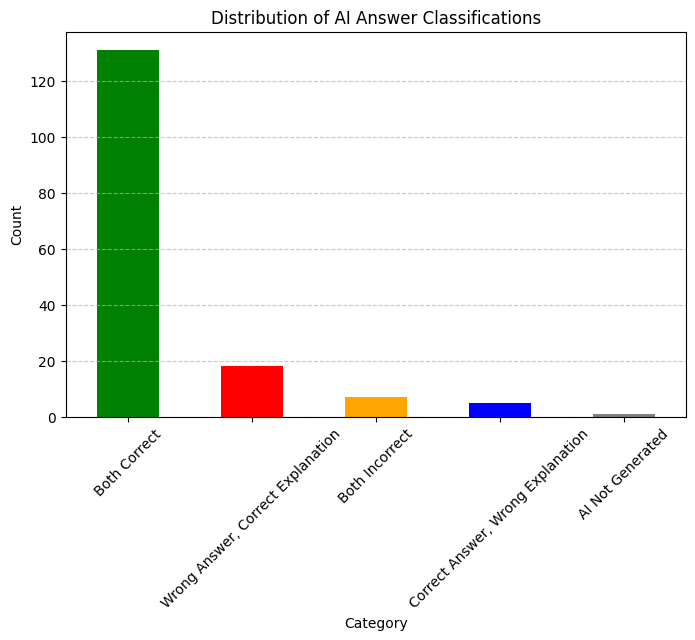

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Count occurrences of each classification category
category_counts = df["Category"].value_counts()

# Compute percentages
category_percentages = (category_counts / len(df)) * 100

# Display statistical summary
print("Statistical Summary of AI Answer Classification:")
print(category_counts)
print("\nPercentage Distribution:")
print(category_percentages)

# Plot bar chart for better visualization
plt.figure(figsize=(8, 5))
category_counts.plot(kind="bar", color=["green", "red", "orange", "blue", "gray"])
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Distribution of AI Answer Classifications")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [13]:
df.to_csv("deepseek_r1_test_results.csv")